In [1]:
!nvidia-smi

Mon Jun 29 19:22:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# Install Detectron2 dependencies: https://detectron2.readthedocs.io/tutorials/install.html (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# !pip install awscli # you'll need this if you want to download images from Open Images (we'll see this later)

# Make sure we can import PyTorch (what Detectron2 is built with)
import torch, torchvision
torch.__version__
!gcc --version

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9MB 24kB/s 
     |████████████████████████████████| 4.1MB 45.7MB/s 
  Found existing installation: torch 1.5.1+cu101
    Uninstalling torch-1.5.1+cu101:
      Successfully uninstalled torch-1.5.1+cu101
  Found existing installation: torchvision 0.6.1+cu101
    Uninstalling torchvision-0.6.1+cu101:
      Successfully uninstalled torchvision-0.6.1+cu101
     |████████████████████████████████| 276kB 7.0MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=e2716d4ded72aecd61fd7d8ec7fb08b7ab0639ebd3e61a8ee51afe47e68fbc7a
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-b

In [4]:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 5.9MB 645kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200623-cp36-none-any.whl size=41183 sha256=7b67cc80e03a5b6a9f2a60e528533f8cc2c7d88c34805935ffdad7f7531e7482
  Stored in directory: /root/.cache/pip/wheels/31/b5/a9/df0fd43b263cc96c1d5076ade63fdcdd30fab8699e3366a60c
Successfully built fvcore


In [8]:
# Some basic setup:
# Setup detectron2 logger
import pdb
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger() # this logs Detectron2 information such as what the model is doing when it's training

# import some common libraries
import numpy as np
# import pandas as pd
# from tqdm import tqdm
import cv2
import random
import time
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo # a series of pre-trained Detectron2 models: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md
from detectron2.engine import DefaultPredictor # a default predictor class to make predictions on an image using a trained model
from detectron2.config import get_cfg # a config of "cfg" in Detectron2 is a series of instructions for building a model
from detectron2.utils.visualizer import Visualizer # a class to help visualize Detectron2 predictions on an image
from detectron2.data import MetadataCatalog # stores information about the model such as what the training/test data is, what the class names are
import os
import numpy as np
import json
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("/content/drive/My Drive/dsip/door_model_config.yaml")
cfg.MODEL.WEIGHTS ="/content/drive/My Drive/dsip/model_final.pth"
cfg.MODEL.SCORE_THRESH_TEST = 0.5
cfg.MODEL.DEVICE='cpu'
cfg.DATASETS.TEST = ("door_train",)
# Setup predictor
predictor = DefaultPredictor(cfg)

# Make a prediction and display inferences
def make_inference_firehydrant(image,predictor, model_config, model_weights, threshold=0.5, n=5):
  """
  Makes inference on image (single image) using model_config, model_weights and threshold.

  Returns image with n instance predictions drawn on.

  Params:
  -------
  image (str) : file path to target image
  model_config (str) : file path to model config in .yaml format
  model_weights (str) : file path to model weights 
  threshold (float) : confidence threshold for model prediction, default 0.5
  n (int) : number of prediction instances to draw on, default 5
    Note: some images may not have 5 instances to draw on depending on threshold,
    n=5 means the top 5 instances above the threshold will be drawn on.
  save (bool) : if True will save image with predicted instances to file, default False
  """

  # # Setup config
  # cfg = get_cfg()
  # cfg.merge_from_file(model_config)
  # cfg.MODEL.WEIGHTS = model_weights
  # cfg.MODEL.SCORE_THRESH_TEST = threshold
  # cfg.MODEL.DEVICE='cpu'

  # # Setup predictor
  # predictor = DefaultPredictor(cfg)
  img = cv2.imread(image)
  visualizer = Visualizer(img_rgb=img[:, :, ::-1],
                          metadata=MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
                          scale=0.4)
  
  inference_strat_time = time.time()
  outputs = predictor(img) # Outputs: https://detectron2.readthedocs.io/modules/structures.html#detectron2.structures.Instances
  print('inference_time : '+str(time.time()-inference_strat_time))
  #print(outputs)
  l=len(outputs["instances"])
  bbox = []
  allbox=[]
  scores=[]
  classes=[]
  for i in range(l):
    if outputs["instances"][:l][i].scores.to('cpu').numpy()[0] > threshold:
      s=outputs["instances"][:l][i].scores.to('cpu').numpy()[0]
  
      scores.append(s)
      bbox = outputs["instances"][:l][i].pred_boxes.to('cpu').tensor.numpy()[0].tolist()
      bbox = [int(v) for v in bbox]
      allbox.append(bbox)
      c=outputs["instances"][:l][i].pred_classes.to('cpu').numpy()[0]
      classes.append(c)
  fn_base = image.split('.')[0]  
  # bboxes : outputs["instances"][:1].pred_boxes.to('cpu').tensor.numpy().tolist()
  # score : outputs["instances"][:1].scores.to('cpu').numpy()[0]

  # Draw on predictions to image
  # visualizer = visualizer.draw_instance_predictions(outputs["instances"][:n].to("cpu"))
  # fn_base = image.split('.')[0]
  # cv2.imwrite(f'{fn_base}_output.jpeg', visualizer.get_image()[:, :, ::-1])
  # cv2_imshow(visualizer.get_image()[:, :, ::-1])
  name=fn_base[:]
  return name,allbox,classes,scores





  #cv2_imshow(visualizer.get_image())

inference_time : 13.883843421936035
('4.jpeg', [1, 0, 2], [[1604, 585, 1912, 780], [654, 555, 702, 642], [1173, 642, 1359, 764]], [0.9999994, 0.99849665, 0.95192826])


In [19]:


name,bbox,classes,scores=make_inference_firehydrant('/content/drive/My Drive/dsip/img1.jpeg',predictor,
               model_config="/content/drive/My Drive/dsip/door_model_config.yaml",
               model_weights="/content/drive/My Drive/dsip/model_final.pth",
               n=10)
c=[]
b=[]
s=[]
for i in range(len(classes)):
  if classes[i] not in c:
    c.append(classes[i])
    b.append(bbox[i])
    s.append(scores[i])
print((f'{name[36:]}.jpeg',c,b,s))

inference_time : 8.611046075820923
('.jpeg', [1, 0], [[147, 262, 181, 278], [162, 241, 178, 265]], [0.5453702, 0.5090195])


In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 10.0)
matplotlib.rcParams['image.cmap'] = 'gray'

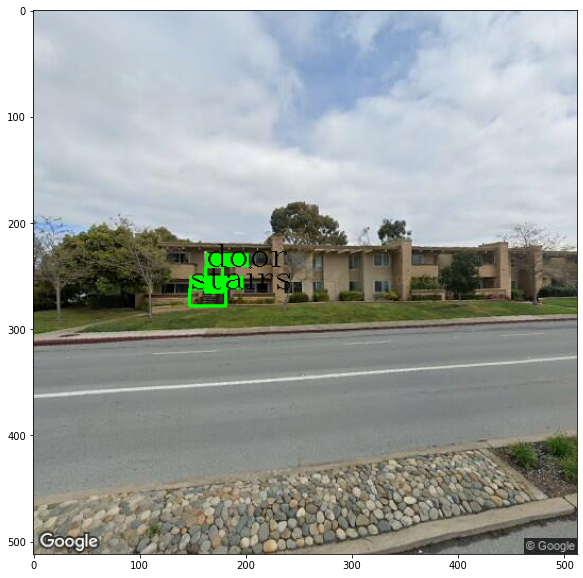

In [30]:
img=cv2.imread('/content/drive/My Drive/dsip/img1.jpeg')
d={0:'door',1:'stairs',2:'irongate',3:'praking'}
for i in range(len(c)):
    # print(box)
    x1,y1,x2,y2 = (b[i][0],b[i][1],b[i][2],b[i][3])
    con = s[i]
    # print(conf)
    cls=c[i]
    label = d[cls]
    
    if con < .5 :
        continue
    # print(x1,y1,x2,y2,conf,label)
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),2)
    labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,.5,1)
    # print('labelSize>>',labelSize)
    _x1 = x1
    _y1 = y1#+int(labelSize[0][1]/2)
    _x2 = _x1+labelSize[0][0]
    _y2 = y1-int(labelSize[0][1])
    cv2.rectangle(img,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
    cv2.putText(img,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,1,(0,0,0),1)


plt.imshow(img[:,:,::-1])

In [ ]:
def drawBoundingBox(self,imgcv,result):
        for i in range(len):
            # print(box)
            x1,y1,x2,y2 = (box[],box[],box[],box[][])
            s = box['confidence']
            # print(conf)
            label = s['label']
            if conf < self.predictThresh:
                continue
            # print(x1,y1,x2,y2,conf,label)
            cv2.rectangle(imgcv,(x1,y1),(x2,y2),(0,255,0),6)
            labelSize=cv2.getTextSize(label,cv2.FONT_HERSHEY_COMPLEX,0.5,2)
            # print('labelSize>>',labelSize)
            _x1 = x1
            _y1 = y1#+int(labelSize[0][1]/2)
            _x2 = _x1+labelSize[0][0]
            _y2 = y1-int(labelSize[0][1])
            cv2.rectangle(imgcv,(_x1,_y1),(_x2,_y2),(0,255,0),cv2.FILLED)
            cv2.putText(imgcv,label,(x1,y1),cv2.FONT_HERSHEY_COMPLEX,0.5,(0,0,0),1)
        return imgcv 

SyntaxError: ignored

In [ ]:
name[35:]





'/4'

In [ ]:
j

[1, 0]

In [ ]:
b

[[1579, 573, 1918, 811], [827, 557, 880, 639]]